In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.utils.data_loader import DataLoader
from src.models.position_classifier import (
    PositionClassifier, PositionClassifierEvaluator
)

In [2]:
cd ..

c:\Users\Serkan\Desktop\digitalpulse-opinion-analyzer


In [ ]:
loader = DataLoader()
topics_df, conclusions_df, opinions_df = loader.load_all_data(clean=True)
opinions_df = pd.DataFrame(pd.read_csv('data/processed/opinions_classified.csv'))
print(f"Loaded {len(opinions_df)} opinions")
print(f"\n Position Distribution:")
print(opinions_df['type'].value_counts())

position_counts = opinions_df['type'].value_counts()
imbalance_ratio = position_counts.max() / position_counts.min()

print(f"\n Class Imbalance Ratio: {imbalance_ratio:.2f}x")
print(f" Most common: {position_counts.index[0]} ({position_counts.iloc[0]} samples)")
print(f" Least common: {position_counts.index[-1]} ({position_counts.iloc[-1]} samples)")

2025-10-21 20:22:26.183 | INFO     | src.utils.data_loader:_load_config:14 - Configuration loaded successfully from configs/config.yaml
2025-10-21 20:22:26.204 | INFO     | src.utils.data_loader:load_topics:27 - Topics data loaded successfully from data\topics_clean.csv
2025-10-21 20:22:26.235 | INFO     | src.utils.data_loader:load_conclusions:40 - Conclusions data loaded successfully from data\conclusions_clean.csv
2025-10-21 20:22:26.436 | INFO     | src.utils.data_loader:load_opinions:53 - Opinions data loaded successfully from data\opinions_clean.csv


Loaded 26690 opinions

 Position Distribution:
type
Claim           11856
Evidence        11825
Counterclaim     1768
Rebuttal         1241
Name: count, dtype: int64

 Class Imbalance Ratio: 9.55x
 Most common: Claim (11856 samples)
 Least common: Rebuttal (1241 samples)


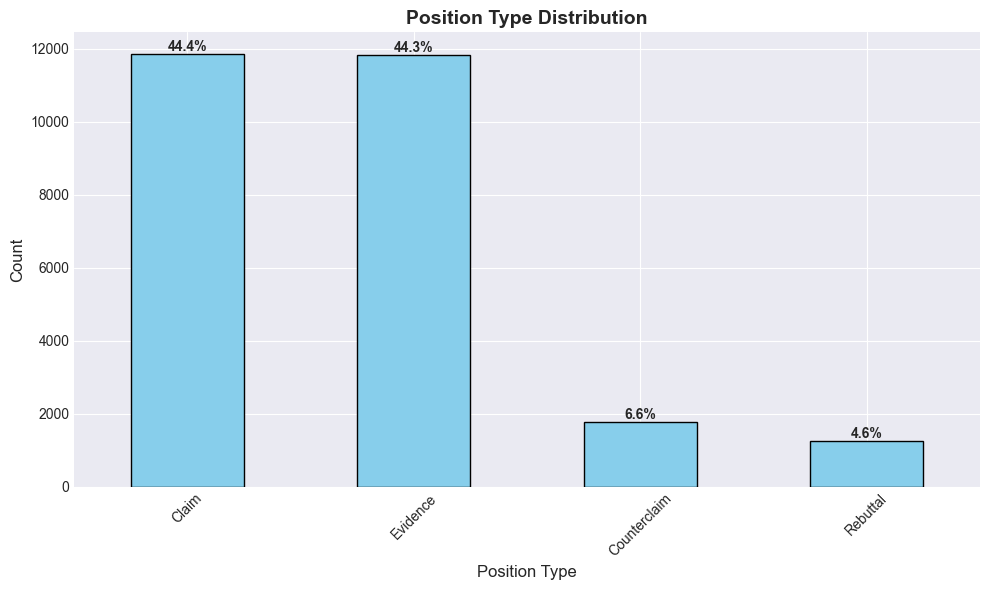

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
position_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Position Type Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Position Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(position_counts.values):
    percentage = (v / len(opinions_df)) * 100
    ax.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*70)
print("INITIALIZING POSITION CLASSIFIER")
print("="*70)

classifier = PositionClassifier()

print(f"Model: {classifier.model_name}")
print(f"Device: {classifier.device}")
print(f"Learning Rate: {classifier.lr}")
print(f"Batch Size: {classifier.batch_size}")
print(f"Epochs: {classifier.epochs}")

train_dataset, val_dataset = classifier.prepare_datasets(
    texts=opinions_df['text'].tolist(),
    labels=opinions_df['type'].tolist(),
    test_size=0.2,
    random_state=42
)

print(f"\n Datasets prepared")
print(f"   Label mappings: {classifier.id2label}")

2025-10-21 20:22:32.873 | INFO     | src.models.position_classifier:__init__:60 - Using device: cpu
2025-10-21 20:22:32.874 | INFO     | src.models.position_classifier:__init__:69 - Loading model: distilbert



INITIALIZING POSITION CLASSIFIER


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-10-21 20:22:34.987 | INFO     | src.models.position_classifier:__init__:87 - Model loaded with 4 labels
2025-10-21 20:22:35.014 | INFO     | src.models.position_classifier:prepare_datasets:104 - Splitting data: 80% train, 20% test
2025-10-21 20:22:35.069 | INFO     | src.models.position_classifier:prepare_datasets:121 - Train samples: 21352
2025-10-21 20:22:35.071 | INFO     | src.models.position_classifier:prepare_datasets:122 - Validation samples: 5338
2025-10-21 20:22:35.072 | INFO     | src.models.position_classifier:prepare_datasets:123 - Labels: {0: np.str_('Claim'), 1: np.str_('Counterclaim'), 2: np.str_('Evidence'), 3: np.str_

Model: distilbert
Device: cpu
Learning Rate: 3e-05
Batch Size: 128
Epochs: 1

 Datasets prepared
   Label mappings: {0: np.str_('Claim'), 1: np.str_('Counterclaim'), 2: np.str_('Evidence'), 3: np.str_('Rebuttal')}


In [7]:
train_labels = [train_dataset.labels[i] for i in range(len(train_dataset))]
val_labels = [val_dataset.labels[i] for i in range(len(val_dataset))]

print(f"\nTraining set distribution:")
for label, count in pd.Series(train_labels).value_counts().items():
    print(f"   {label}: {count}")

print(f"\n Validation set distribution:")
for label, count in pd.Series(val_labels).value_counts().items():
    print(f"   {label}: {count}")


Training set distribution:
   Claim: 9485
   Evidence: 9460
   Counterclaim: 1414
   Rebuttal: 993

 Validation set distribution:
   Claim: 2371
   Evidence: 2365
   Counterclaim: 354
   Rebuttal: 248


In [ ]:
classifier.train(train_dataset, val_dataset)

classifier.plot_training_history(output_path='docs/training_history.png')

2025-10-21 20:22:43.774 | INFO     | src.models.position_classifier:train:139 - Starting training for 1 epochs



 Epoch 1/1
------------------------------------------------------------


Training:   9%|▉         | 15/167 [07:05<1:09:18, 27.36s/it]


VALIDATION SET EVALUATION


Predicting: 100%|██████████| 42/42 [02:55<00:00,  4.19s/it]



 Metrics:
  • accuracy                      : 0.7280
  • precision_weighted            : 0.8092
  • precision_macro               : 0.5901
  • recall_weighted               : 0.7280
  • recall_macro                  : 0.7139
  • f1_weighted                   : 0.7543
  • f1_macro                      : 0.6109

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Claim       0.82      0.73      0.77      2371
Counterclaim       0.32      0.68      0.44       354
    Evidence       0.92      0.73      0.82      2365
    Rebuttal       0.29      0.71      0.41       248

    accuracy                           0.73      5338
   macro avg       0.59      0.71      0.61      5338
weighted avg       0.81      0.73      0.75      5338



2025-10-20 19:52:29.164 | INFO     | src.models.position_classifier:plot_confusion_matrix:386 - Confusion matrix saved to docs/confusion_matrix_position.png


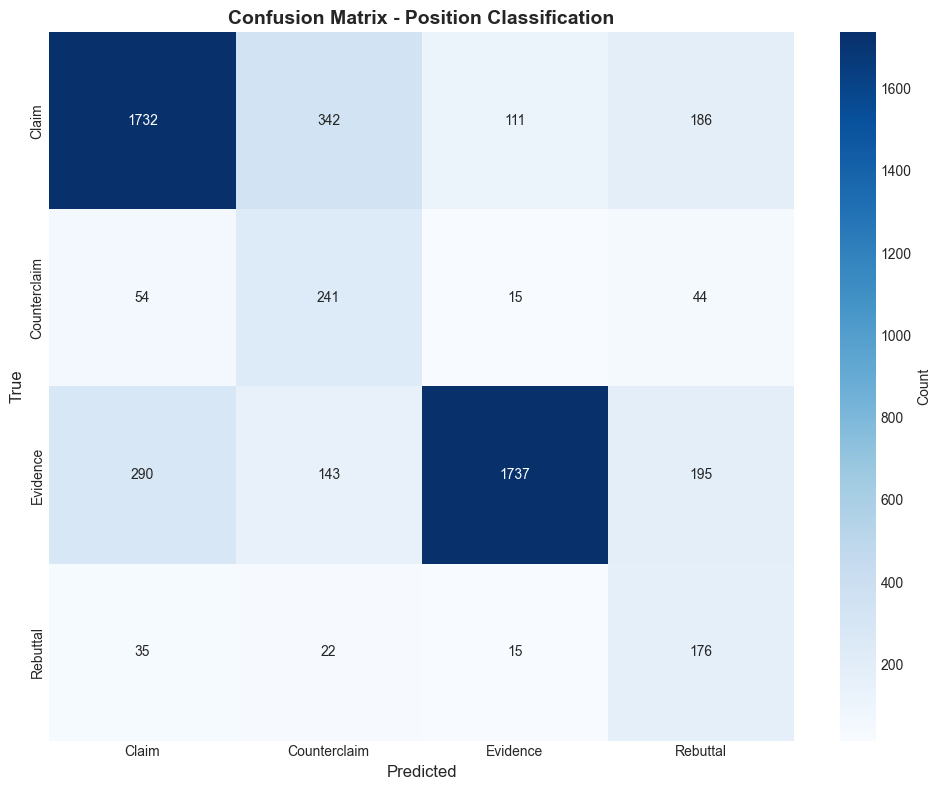

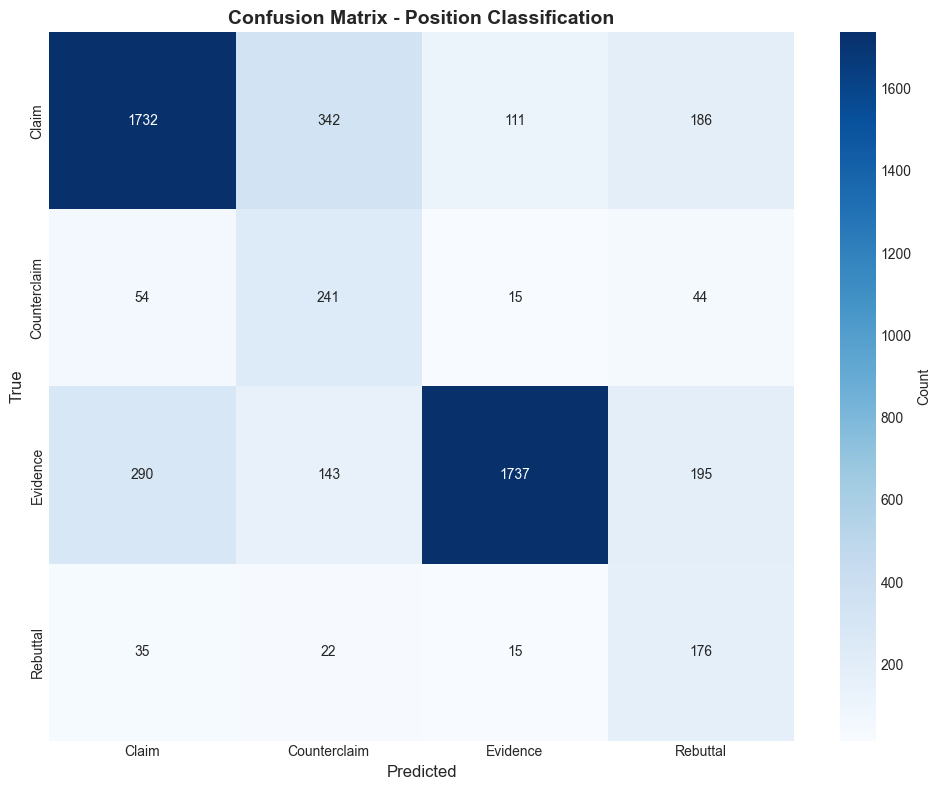

In [8]:
print("\n" + "="*70)
print("VALIDATION SET EVALUATION")
print("="*70)
print(val_dataset)

val_texts = [val_dataset.texts[i] for i in range(len(val_dataset))]
val_true_labels = list(val_labels)

pred_labels, probs = classifier.predict(val_texts)

evaluator = PositionClassifierEvaluator()
metrics = evaluator.calculate_metrics(val_true_labels, pred_labels, probs)

print("\n Metrics:")
for key, value in metrics.items():
    print(f"  • {key:<30}: {value:.4f}")

evaluator.print_classification_report(val_true_labels, pred_labels)

evaluator.plot_confusion_matrix(
    val_true_labels,
    pred_labels,
    output_path='docs/confusion_matrix_position.png'
)

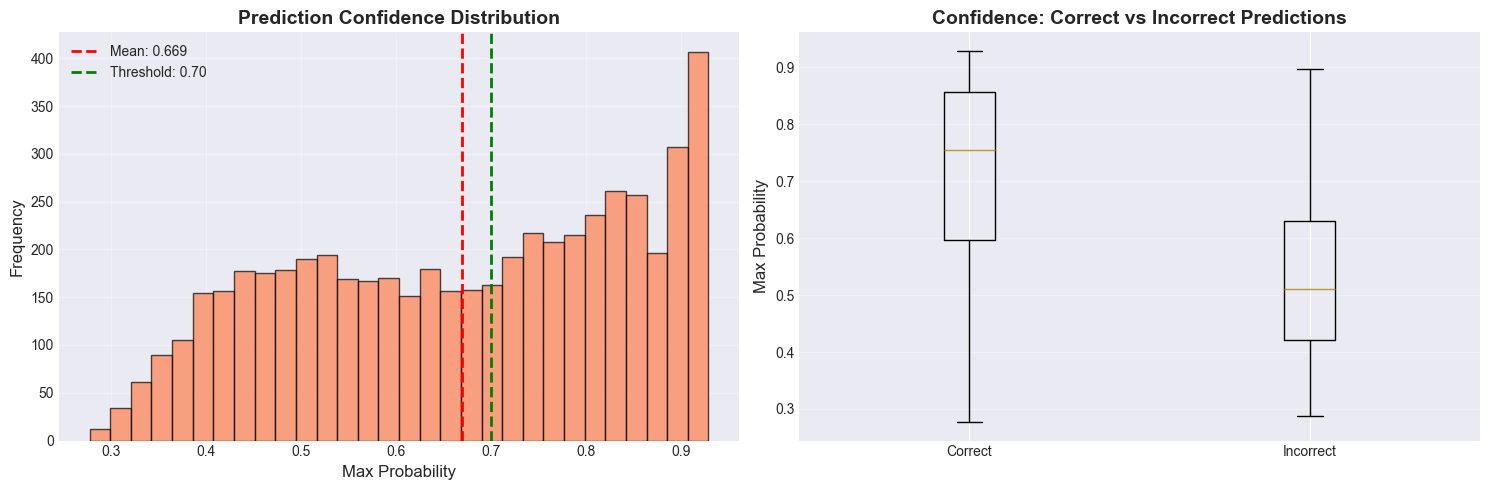


 Confidence Analysis:
  • Correct predictions - Mean: 0.7200, Std: 0.1613
  • Incorrect predictions - Mean: 0.5341, Std: 0.1418


In [ ]:
max_probs = np.max(probs, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(max_probs, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(max_probs), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(max_probs):.3f}')
axes[0].axvline(0.7, color='green', linestyle='--', 
               linewidth=2, label='Threshold: 0.70')
axes[0].set_xlabel('Max Probability', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Correct vs Incorrect predictions
correct_mask = np.array(pred_labels) == np.array(val_true_labels)
correct_probs = max_probs[correct_mask]
incorrect_probs = max_probs[~correct_mask]

data_to_plot = [correct_probs, incorrect_probs]
axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'])
axes[1].set_ylabel('Max Probability', fontsize=12)
axes[1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('docs/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Confidence Analysis:")
print(f"  • Correct predictions - Mean: {correct_probs.mean():.4f}, Std: {correct_probs.std():.4f}")
print(f"  • Incorrect predictions - Mean: {incorrect_probs.mean():.4f}, Std: {incorrect_probs.std():.4f}")


CLASSIFYING ALL OPINIONS


Predicting: 100%|██████████| 209/209 [19:38<00:00,  5.64s/it]



 Classified 26690 opinions
Accuracy on full dataset: 0.7324


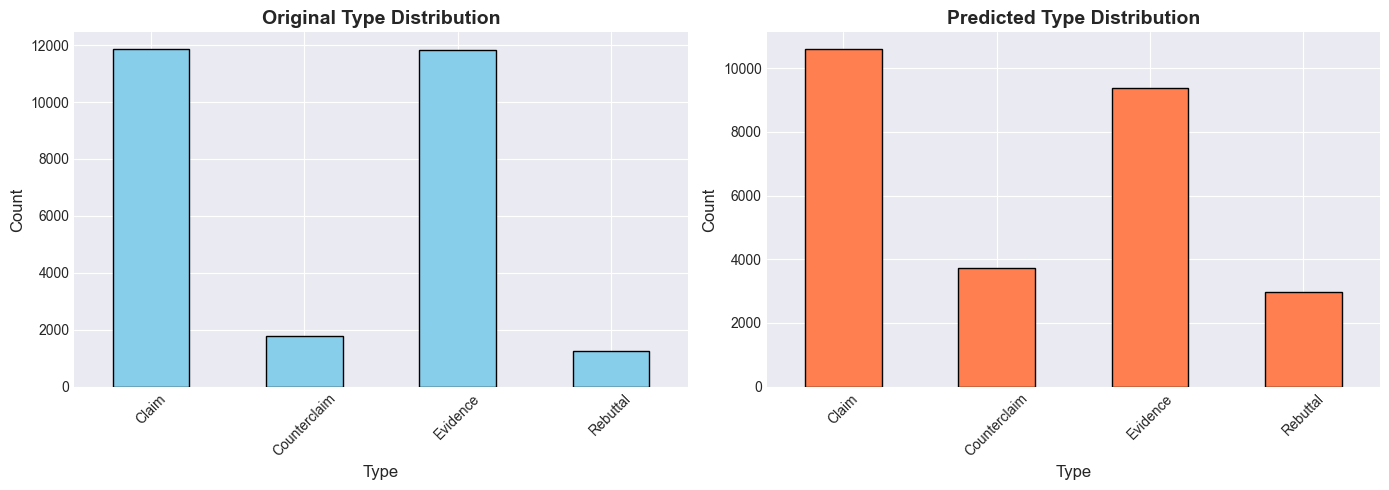

In [ ]:
# Classify all opinions
print("\n" + "="*70)
print("CLASSIFYING ALL OPINIONS")
print("="*70)

all_pred_labels, all_probs = classifier.predict(opinions_df['text'].tolist())

opinions_df['predicted_type'] = all_pred_labels
opinions_df['type_confidence'] = np.max(all_probs, axis=1)

print(f"\n Classified {len(opinions_df)} opinions")

accuracy = (opinions_df['predicted_type'] == opinions_df['type']).mean()
print(f"Accuracy on full dataset: {accuracy:.4f}")

# Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

opinions_df['type'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='skyblue', edgecolor='black'
)
axes[0].set_title('Original Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Predicted distribution
opinions_df['predicted_type'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color='coral', edgecolor='black'
)
axes[1].set_title('Predicted Type Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('docs/distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save full opinions with predictions and matches
opinions_df.to_csv('data/processed/opinions_classified.csv', index=False)

# Save training history
history_df = pd.DataFrame(classifier.history)
history_df.to_csv('data/processed/training_history.csv', index=False)

# Save model
classifier.save_model('models/position_classifier')



SAVING RESULTS


2025-10-20 20:12:09.310 | INFO     | src.models.position_classifier:save_model:307 - Model saved to models/position_classifier


In [ ]:
# Final Summary
print("\n" + "="*70)
print("PHASE 2 SUMMARY")
print("="*70)

summary_stats = {
    'Total Opinions': len(opinions_df),
    'Model Accuracy (Validation)': f"{metrics['accuracy']:.4f}",
    'F1-Score (Weighted)': f"{metrics['f1_weighted']:.4f}",
    'F1-Score (Macro)': f"{metrics['f1_macro']:.4f}",
    'Position Types': len(classifier.id2label),
    'Model': classifier.model_name,
    'Device': classifier.device,
}

for key, value in summary_stats.items():
    print(f"  • {key:<30}: {value}")

print(f"\n Outputs Generated:")
print(f"   - ../docs/position_distribution_detailed.png")
print(f"   - ../docs/training_history.png")
print(f"   - ../docs/confusion_matrix_position.png")
print(f"   - ../docs/confidence_analysis.png")
print(f"   - ../docs/distribution_comparison.png")
print(f"   - ../data/processed/opinions_classified.csv")
print(f"   - ../models/position_classifier/")

print(f"\nPosition Classification Phase Completed!")


PHASE 2 SUMMARY
  • Total Opinions                : 26690
  • Model Accuracy (Validation)   : 0.7280
  • F1-Score (Weighted)           : 0.7543
  • F1-Score (Macro)              : 0.6109
  • Position Types                : 4
  • Model                         : distilbert
  • Device                        : cpu

 Outputs Generated:
   - ../docs/position_distribution_detailed.png
   - ../docs/training_history.png
   - ../docs/confusion_matrix_position.png
   - ../docs/confidence_analysis.png
   - ../docs/distribution_comparison.png
   - ../data/processed/opinions_classified.csv
   - ../models/position_classifier/

Position Classification Phase Completed!
